In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

import utils

In [54]:
X_train, y_train, X_test, y_test = utils.load_mnist()

In [55]:
X_train = X_train.reshape((60000, 784))

X_train = np.array([ fftpack.dct(x) for x in X_train])

In [61]:
print(X_train.min())
print(X_train.max())

-317.0583
623.3961


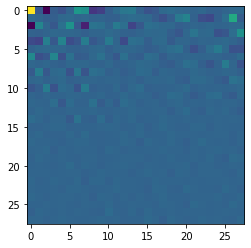

In [66]:
idx = 5000
plt.imshow(((X_train[idx] - X_train[idx].min()) / (X_train[idx].max() - X_train[idx].min())).reshape((28,28))) # Matrix values scaled for visualization
plt.show()

In [68]:
(X_train[idx] != 0).sum().item()

784

In [41]:
dct = fftpack.dct(img.squeeze())

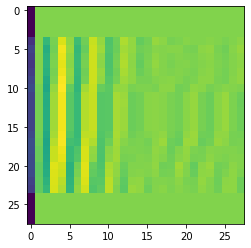

In [42]:
plt.imshow((dct - dct.min()) / (dct.max() - dct.min())) # Matrix values scaled for visualization
plt.show()

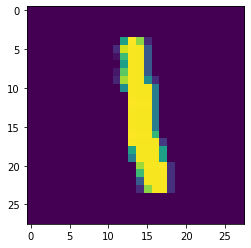

In [44]:
idct = fftpack.idct(dct)

plt.imshow((idct - idct.min()) / (idct.max() - idct.min())) # Matrix values scaled for visualization
plt.show()

In [45]:
print(dct.max())
print(dct.min())

6.540773
-28.0


In [34]:
dct.reshape((60))

array([[-2.80000000e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -4.64881850e-07,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -9.32015780e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -7.43257829e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.06106256e-07,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.80000000e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -4.64881850e-07,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -9.32015780e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -7.43257829e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00

In [33]:
(dct != 0).shape

(60000, 28, 28)

### Visualize DCT Clusters with TSNE

In [3]:
from sklearn.manifold import TSNE

# Load Model - used to get model outputs
model = utils.load_VGG('trained_models/initial_model.pt')

# Select two classes from the dataset and number of samples from each to visualize with TSNE
samples_per_class = 892 # Samples per class must be lower than the number of samples per class in the dataset
other_digit = 0
sample_digit = 1
epsilon = 1e-1 # Magnitude of adversarial noise

other_digit_indices = np.where(y_test == other_digit)[0]
sample_digit_indices = np.where(y_test == sample_digit)[0]

# Index into X_test to get data for clustering as well as sample of interest
data = np.concatenate((X_test[other_digit_indices[:samples_per_class]], 
                       X_test[sample_digit_indices[:samples_per_class]]), axis=0)
labels = np.append(np.ones((1, samples_per_class), dtype=np.uint8) * other_digit, 
                   np.ones((1, samples_per_class + 1), dtype=np.uint8) * sample_digit).squeeze()
sample = X_test[sample_digit_indices[np.random.randint(0, samples_per_class)]]

# Generate adversarial version of sample of interest
dataloader = utils.create_dataloader([sample], np.ones((1), dtype=np.uint8) * sample_digit)
adv_samples = utils.add_adversarial_noise(model, dataloader, eps=epsilon)
sample = adv_samples[0]

# Append sample of interest to clustering data and keep track of its index in the dataset
sample_idx = data.shape[0]
data = np.append(data, np.expand_dims(sample, axis=0), axis=0) # Input to CNN

# Transform data using DCT
dct_data = fftpack.dct(data - 0.5) # Used for clustering the input space

# Get model outputs on test data (not transformed by DCT)
testloader = utils.create_dataloader(data, labels)

outputs = utils.get_network_outputs(model, testloader)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


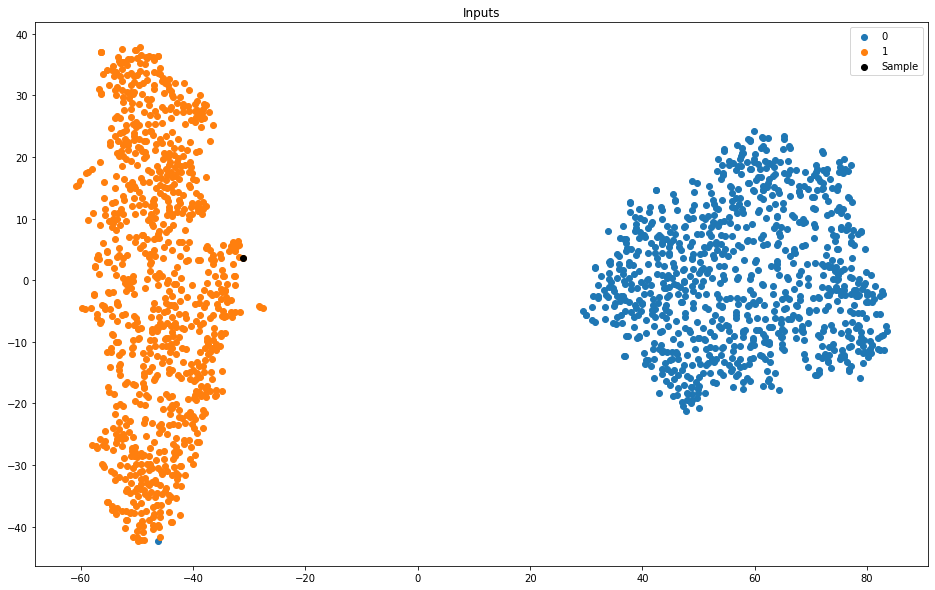

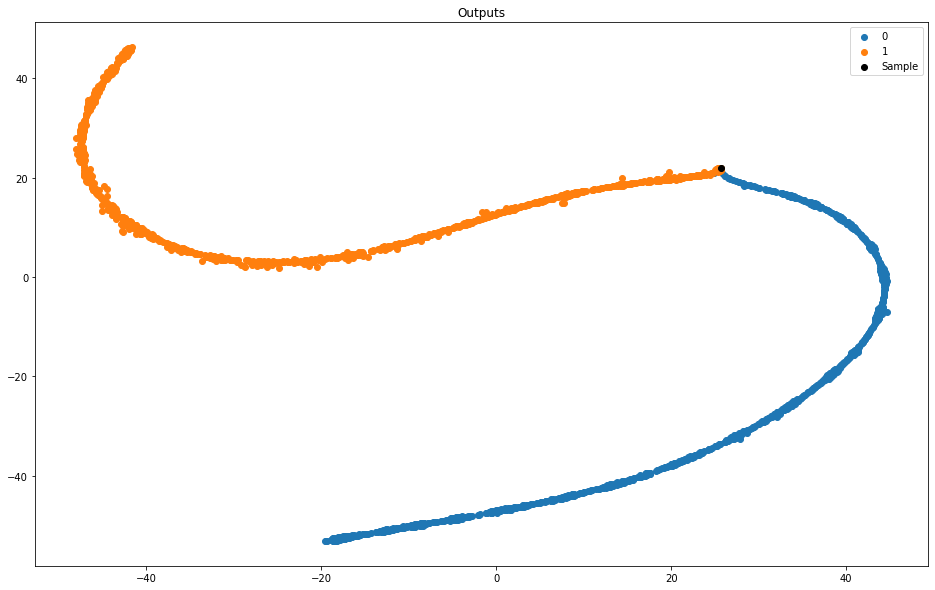

In [4]:
clusters = [dct_data, outputs]

for i, cluster in enumerate(clusters):
    x = cluster
    if (x.ndim > 2): # Flatten data
        x = x.reshape(x.shape[0], -1)
    tsne_output = TSNE(n_components=2, perplexity = 50, n_iter = 50000, learning_rate = 200.0, init='random').fit_transform(x)

    # For each unique class of the passed-in data, plot the TSNE embedding of that data
    classes = np.unique(labels)
    plt.figure(figsize=(16,10))
    for val in classes:
        class_indices = np.where(labels == val)
        plt.scatter(tsne_output[class_indices,0], tsne_output[class_indices,1], label=str(val))
    # Plot the sample on the same graph
    plt.scatter(tsne_output[sample_idx,0], tsne_output[sample_idx,1], label="Sample", c="#000000")

    # Label plot appropriately
    if (i == 0):
        plt.title("Inputs")
    elif(i == (len(clusters) - 1)):
        plt.title("Outputs")
    else:
        plt.title("Output layer %d" % i)
    plt.legend()
    plt.show()

In [29]:
fftpack.dct(np.asarray([[-.5, .5, 0], [.5, -.5, 0]]))

array([[ 0.       , -0.8660254, -1.5      ],
       [ 0.       ,  0.8660254,  1.5      ]])

In [20]:
X_train.min()

0.0